In [54]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns
import scipy

In [35]:
%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2})

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [16]:
query = """

SELECT
    *,
    CASE 
    WHEN ms_course_program_number::int < 5 THEN 'Unit 1'
    WHEN ms_course_program_number::int < 8 THEN 'Unit 2'
    WHEN ms_course_program_number::int < 11 THEN 'Unit 3'
    ELSE NULL
    END AS ms_course_program_group
FROM
(
SELECT
    a.course_number,
    a.course_id AS lower_course_id,
    b.course_id AS higher_course_id,
    e.program_type,
    e.program_title,
    CASE
        WHEN a.course_seat_price BETWEEN 20 AND 35 AND b.course_seat_price BETWEEN 45 AND 55 THEN '25 to 50'
        WHEN a.course_seat_price BETWEEN 45 AND 55 AND b.course_seat_price BETWEEN 95 AND 105 THEN '49 to 99'
        ELSE 'other'
    END AS price_increase_grouping,
    	CASE
		WHEN a.course_subject IN
		(
			'Biology & Life Sciences',
			'Chemistry',
			'Computer Science',
			'Data Analysis & Statistics',
			'Electronics',
			'Energy & Earth Sciences',
			'Engineering',
			'Math',
			'Physics',
			'Science'
		) THEN 'STEM'
        WHEN a.course_subject LIKE '%Business%' THEN a.course_subject
		ELSE 'non-STEM'
	END AS stem_non_stem,
    CASE
        WHEN b.course_id = 'course-v1:Microsoft+DAT101x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT101x+1T2017' THEN  '1'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT201x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT201x+1T2017' THEN  '2'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT206x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT206x+1T2017' THEN  '3'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT207x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT207x+1T2017' THEN  '3'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT222x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT222x+1T2017'  THEN  '4'
        WHEN b.course_id = 'course-v1:Microsoft+DAT204x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT204x+1T2017' THEN  '5'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT208x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT208x+1T2017' THEN  '5'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT203.1x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT203.1x+1T2017'   THEN  '6' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT203.2x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT203.2x+1T2017'   THEN  '7' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT209x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT209x+1T2017' THEN  '8'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT210x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT210x+1T2017' THEN  '8'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT203.3x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT203.3x+1T2017'   THEN  '9' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT211x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT211x+1T2017' THEN  '9'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT202.3x+2T2017' AND a.course_id ='course-v1:Microsoft+DAT202.3x+1T2017'   THEN  '9' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT213x+3T2017' AND a.course_id =  'course-v1:Microsoft+DAT213x+3T2017' THEN  '9'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT102x+1T2017' AND a.course_id =  'course-v1:Microsoft+DAT102x+1T2017' THEN  '10'  
        WHEN b.course_id = 'course-v1:Microsoft+DAT102x+2T2017'  AND a.course_id = 'course-v1:Microsoft+DAT102x+1T2017' THEN '10'
        ELSE NULL
        END AS ms_course_program_number,
    e.program_slot_number::varchar,
    a.pacing_type,
    a.course_partner,
    a.course_subject,
    a.level_type,
    a.course_verification_end_date AS lower_course_verification_end_date, 
    b.course_verification_end_date AS higher_course_verification_end_date,
    a.course_seat_price AS lower_course_price,
    b.course_seat_price AS higher_course_price,
    (b.course_seat_price - a.course_seat_price) AS price_difference,
    c.sum_enrolls_vtr AS lower_course_enrolls,
    c.sum_verifications AS lower_course_verifications,
    c.sum_bookings AS lower_course_bookings,
    c.vtr * 100.0 AS lower_course_vtr,
    d.sum_enrolls_vtr AS higher_course_enrolls,
    d.sum_verifications AS higher_course_verifications,
    (d.sum_verifications - f.cnt_discounted_verifications) AS higher_course_verifications_minus_vouchers,
    d.sum_bookings AS higher_course_bookings,
    d.vtr * 100.0 AS higher_course_vtr,
    ((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))*100.0/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) AS undiscounted_vtr,
    (b.course_seat_price - a.course_seat_price) * 100.0/(a.course_seat_price) AS pct_difference_price,
    (d.vtr - c.vtr)*100.0/(c.vtr) AS pct_difference_vtr,
    (((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) - c.vtr)*100.0/(c.vtr) AS pct_difference_undiscounted_vtr,
    ((d.vtr - c.vtr)/(c.vtr)) / ((b.course_seat_price - a.course_seat_price)/(a.course_seat_price)) AS price_elasticity,
    c.vtr * a.course_seat_price AS expected_value_lower,
    d.vtr * b.course_seat_price AS expected_value_higher,
    d.vtr * g.avg_transaction_amount AS expected_value_higher_actual_price,
    ((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) * b.course_seat_price AS expected_value_higher_undiscounted,
    ((d.vtr * b.course_seat_price) - (c.vtr * a.course_seat_price)) *100.0 / (c.vtr * a.course_seat_price) AS pct_difference_expected_value,
    ((d.vtr * g.avg_transaction_amount) - (c.vtr * a.course_seat_price)) *100.0 / (c.vtr * a.course_seat_price) AS pct_difference_expected_value_actual_price,
    ((((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) * b.course_seat_price) - (c.vtr * a.course_seat_price)) *100.0 / (c.vtr * a.course_seat_price) AS pct_difference_expected_value_undiscounted,
    CASE WHEN (b.course_seat_price)/(a.course_seat_price) * (d.vtr)/(c.vtr) < 1 THEN 1 ELSE 0 END AS is_worse,
    CASE 
        WHEN a.course_verification_end_date > b.course_verification_end_date THEN YEAR(a.course_verification_end_date)
        ELSE YEAR(b.course_verification_end_date)
    END AS year
FROM
    business_intelligence.course_master a
JOIN
    business_intelligence.course_master b
ON
    a.course_number = b.course_number
AND
    a.course_id != b.course_id
AND
    a.course_verification_end_date <= CURRENT_DATE()
AND
    b.course_verification_end_date <= CURRENT_DATE()
AND
    a.is_wl = 0
AND
    ABS(DATEDIFF('day', a.course_verification_end_date, b.course_verification_end_date)) < 364
AND
    (b.course_seat_price - a.course_seat_price) >= 5
AND
    a.pacing_type = b.pacing_type
AND
    a.level_type = b.level_type
JOIN
    business_intelligence.course_stats_summary c
ON
    a.course_id = c.course_id
AND
    c.sum_enrolls > 200
JOIN
    business_intelligence.course_stats_summary d
ON
    b.course_id = d.course_id
AND
    d.sum_enrolls > 200
LEFT JOIN
    production.d_program_course e
ON
    a.course_id = e.course_id
LEFT JOIN
(
    SELECT
        course_id,
        COUNT(1) as cnt_discounted_verifications
    FROM 
        business_intelligence.voucher_redemption
    WHERE 
        voucher_code = 'MPP50'
    GROUP BY 
        course_id
) f
ON
    b.course_id = f.course_id
LEFT JOIN
(
    select order_course_id AS course_id, avg(transaction_amount) AS avg_transaction_amount
    from finance.f_orderitem_transactions
    where order_course_id IN
    (
    'course-v1:Microsoft+DAT202.3x+2T2017',
    'course-v1:Microsoft+DAT203.3x+2T2017',
    'course-v1:Microsoft+DAT211x+2T2017',
    'course-v1:Microsoft+DAT209x+2T2017',
    'course-v1:Microsoft+DAT210x+2T2017',
    'course-v1:Microsoft+DAT203.2x+2T2017',
    'course-v1:Microsoft+DAT203.1x+2T2017',
    'course-v1:Microsoft+DAT204x+2T2017',
    'course-v1:Microsoft+DAT208x+2T2017',
    'course-v1:Microsoft+DAT206x+2T2017',
    'course-v1:Microsoft+DAT207x+2T2017',
    'course-v1:Microsoft+DAT201x+2T2017',
    'course-v1:Microsoft+DAT101x+2T2017'

    ) 
    and transaction_date is not null
    and transaction_type = 'sale'
    and order_product_class = 'seat'
    and order_voucher_code IN ('', 'MPP50')
    group by 1
) g
ON
    b.course_id = g.course_id
) a
"""

In [17]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(query)
extract = cur.fetchall()
df = pd.DataFrame(extract)

connection.close()

In [18]:
df.head()

,course_number,lower_course_id,higher_course_id,program_type,program_title,price_increase_grouping,stem_non_stem,ms_course_program_number,program_slot_number,pacing_type,...,expected_value_lower,expected_value_higher,expected_value_higher_actual_price,expected_value_higher_undiscounted,pct_difference_expected_value,pct_difference_expected_value_actual_price,pct_difference_expected_value_undiscounted,is_worse,year,ms_course_program_group
0,GeorgetownX+PHYX152x,course-v1:GeorgetownX+PHYX152x+2016_T1,GeorgetownX/PHYX152x/1T2015,None,None,49 to 99,STEM,None,None,instructor_paced,...,0.391738,0.017409,NaN,0.017409,-95.555837,NaN,-95.555837,1,2016,None
1,McGillX+Body101x,course-v1:McGillX+Body101x+1T2016,McGillX/Body101x/1T2015,None,None,49 to 99,non-STEM,None,None,instructor_paced,...,0.391806,0.295262,NaN,0.295262,-24.640810,NaN,-24.640810,1,2016,None
2,BUx+Math226.2x,course-v1:BUx+Math226.2x+2T2015,course-v1:BUx+Math226.2x+1T2016,None,None,25 to 50,STEM,None,None,instructor_paced,...,0.342298,0.605873,NaN,0.605873,77.001546,NaN,77.001546,0,2016,None
3,BUx+PY1x,BUx/PY1x/1T2015,course-v1:BUx+PY1x+3T2015,None,None,25 to 50,STEM,None,None,instructor_paced,...,0.187822,0.188800,NaN,0.188800,0.520851,NaN,0.520851,0,2016,None
4,BerkeleyX+CS169.1x,course-v1:BerkeleyX+CS169.1x+3T2015,course-v1:BerkeleyX+CS169.1x+3T2015SP,Professional Certificate,Agile Development Using Ruby on Rails,49 to 99,STEM,None,1,instructor_paced,...,0.762278,0.779889,NaN,0.779889,2.310340,NaN,2.310340,0,2016,None


In [19]:
#df['vtr'] = df.vtr.astype(float)
df['pct_difference_vtr'] = df.pct_difference_vtr.astype(float)
df['pct_difference_undiscounted_vtr'] = df.pct_difference_undiscounted_vtr.astype(float)

* * *

## Now let's try to find how much VTR varies as a function of price

In [20]:
df.columns

Index(['course_number', 'lower_course_id', 'higher_course_id', 'program_type',
       'program_title', 'price_increase_grouping', 'stem_non_stem',
       'ms_course_program_number', 'program_slot_number', 'pacing_type',
       'course_partner', 'course_subject', 'level_type',
       'lower_course_verification_end_date',
       'higher_course_verification_end_date', 'lower_course_price',
       'higher_course_price', 'price_difference', 'lower_course_enrolls',
       'lower_course_verifications', 'lower_course_bookings',
       'lower_course_vtr', 'higher_course_enrolls',
       'higher_course_verifications',
       'higher_course_verifications_minus_vouchers', 'higher_course_bookings',
       'higher_course_vtr', 'undiscounted_vtr', 'pct_difference_price',
       'pct_difference_vtr', 'pct_difference_undiscounted_vtr',
       'price_elasticity', 'expected_value_lower', 'expected_value_higher',
       'expected_value_higher_actual_price',
       'expected_value_higher_undiscounted', 'pc

In [29]:
df.groupby(['stem_non_stem','lower_course_price','higher_course_price']).count()

course_number  \
stem_non_stem         lower_course_price higher_course_price                  
Business & Management 25.0               50.0                             2   
                                         79.0                             1   
                                         150.0                            1   
                      40.0               60.0                             1   
                                         75.0                             1   
                      49.0               99.0                             6   
                                         150.0                            1   
                      50.0               150.0                            2   
                      79.0               150.0                            1   
                      100.0              125.0                            3   
                                         150.0                            2   
STEM                  25.0               49.0                            13   
                                         50.0                             1   
                                         99.0                             3   
                      30.0               50.0                             2   
                      35.0               50.0                             3   
                      49.0               90.0                             6   
                                         99.0                            74   
                      50.0               99.0                             3   
                                         100.0                            1   
                      90.0               99.0                             4   
                      99.0               129.0                            3   
non-STEM              25.0               49.0                             4   
                      49.0               100.0                            3   
                      50.0               100.0                            1   
                                         150.0                            1   
                      250.0              300.0                            1   

                                                              lower_course_id  \
stem_non_stem         lower_course_price higher_course_price                    
Business & Management 25.0               50.0                               2   
                                         79.0                               1   
                                         150.0                              1   
                      40.0               60.0                               1   
                                         75.0                               1   
                      49.0               99.0                               6   
                                         150.0                              1   
                      50.0               150.0                              2   
                      79.0               150.0                              1   
                      100.0              125.0                              3   
                                         150.0                              2   
STEM                  25.0               49.0                              13   
                                         50.0                               1   
                                         99.0                               3   
                      30.0               50.0                               2   
                      35.0               50.0                               3   
                      49.0               90.0                               6   
                                         99.0                              74   
                      50.0               99.0                               3   
                                         100.0                       

In [31]:
df[df['course_partner']!='Microsoft'].groupby(['price_increase_grouping','stem_non_stem']).count()

course_number  lower_course_id  \
price_increase_grouping stem_non_stem                                           
25 to 50                Business & Management              2                2   
                        STEM                              18               18   
                        non-STEM                           4                4   
49 to 99                STEM                               7                7   
                        non-STEM                           4                4   
other                   Business & Management             13               13   
                        STEM                               3                3   
                        non-STEM                           2                2   

                                               higher_course_id  program_type  \
price_increase_grouping stem_non_stem                                           
25 to 50                Business & Management                 2             2   
                        STEM                                 18             3   
                        non-STEM                              4             0   
49 to 99                STEM                                  7             6   
                        non-STEM                              4             0   
other                   Business & Management                13             7   
                        STEM                                  3             3   
                        non-STEM                              2             1   

                                               program_title  \
price_increase_grouping stem_non_stem                          
25 to 50                Business & Management              2   
                        STEM                               3   
                        non-STEM                           0   
49 to 99                STEM                               6   
                        non-STEM                           0   
other                   Business & Management              7   
                        STEM                               3   
                        non-STEM                           1   

                                               ms_course_program_number  \
price_increase_grouping stem_non_stem                                     
25 to 50                Business & Management                         0   
                        STEM                                          0   
                        non-STEM                                      0   
49 to 99                STEM                                          0   
                        non-STEM                                      0   
other                   Business & Management                         0   
                        STEM                                          0   
                        non-STEM                                      0   

                                               program_slot_number  \
price_increase_grouping stem_non_stem                                
25 to 50                Business & Management                    2   
                        STEM                                     3   
                        non-STEM                                 0   
49 to 99                STEM                                     6   
                        non-STEM                                 0   
other                   Business & Management                    7   
                        STEM                                     3   
                        non-STEM                                 1   

                                               pacing_type  course_partner  \
price_increase_grouping stem_non_stem                                        
25 to 50                Business & Management            2               2   
                        STEM                            18              18   
                    

In [23]:
df['pct_difference_vtr_fixed'] = np.where(df['pct_difference_vtr']>0, 0, df['pct_difference_vtr'])
df['pct_difference_vtr_fixed'] = df['pct_difference_vtr_fixed'].astype('float64')

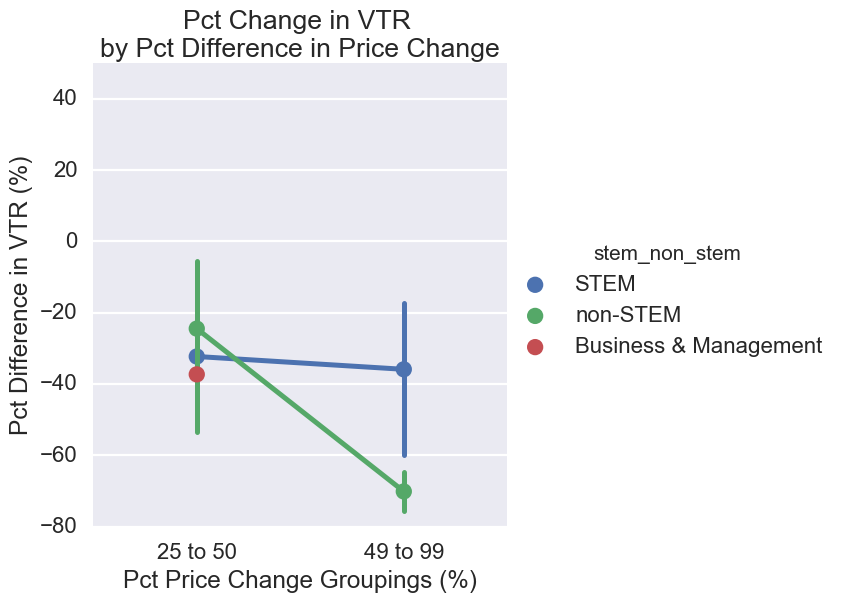

In [24]:
ax = sns.factorplot(data = df[df['course_partner']!='Microsoft'], 
               x = 'price_increase_grouping', 
               y = 'pct_difference_vtr_fixed', 
               size = 6,
                hue = 'stem_non_stem',
                   order = ['25 to 50', '49 to 99'])
ax.set(title = 'Pct Change in VTR \nby Pct Difference in Price Change',
      xlabel = 'Pct Price Change Groupings (%)',
      ylabel = 'Pct Difference in VTR (%)',
      ylim = (-80, 50))

## Price Elasticity
 * * *

In [47]:
df.columns

Index(['course_number', 'lower_course_id', 'higher_course_id', 'program_type',
       'program_title', 'price_increase_grouping', 'stem_non_stem',
       'ms_course_program_number', 'program_slot_number', 'pacing_type',
       'course_partner', 'course_subject', 'level_type',
       'lower_course_verification_end_date',
       'higher_course_verification_end_date', 'lower_course_price',
       'higher_course_price', 'price_difference', 'lower_course_enrolls',
       'lower_course_verifications', 'lower_course_bookings',
       'lower_course_vtr', 'higher_course_enrolls',
       'higher_course_verifications',
       'higher_course_verifications_minus_vouchers', 'higher_course_bookings',
       'higher_course_vtr', 'undiscounted_vtr', 'pct_difference_price',
       'pct_difference_vtr', 'pct_difference_undiscounted_vtr',
       'price_elasticity', 'expected_value_lower', 'expected_value_higher',
       'expected_value_higher_actual_price',
       'expected_value_higher_undiscounted', 'pc

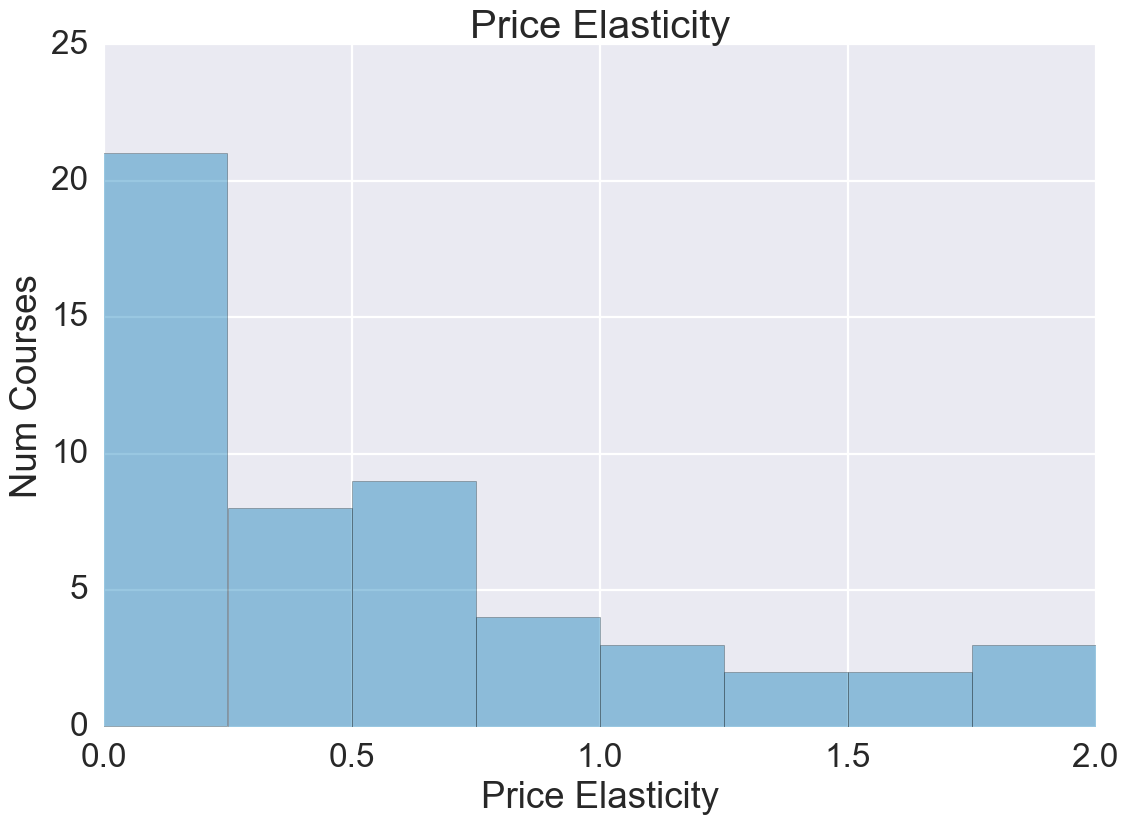

In [68]:
ax = sns.distplot(
    abs(df[df.course_partner!='Microsoft'].price_elasticity),
    kde = False,
    color = '#0075b4',
    bins = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2])
ax.set(
    title = 'Price Elasticity',
    xlabel = 'Price Elasticity',
    ylabel = 'Num Courses'
)

In [52]:
df.mean()

lower_course_price                               49.763889
higher_course_price                              94.854167
price_difference                                 45.090278
lower_course_enrolls                          13732.243056
lower_course_verifications                      487.423611
higher_course_enrolls                         12066.750000
higher_course_verifications                     402.194444
higher_course_verifications_minus_vouchers      659.333333
pct_difference_price                            101.589311
pct_difference_vtr                               -3.754072
pct_difference_undiscounted_vtr                 -16.739584
price_elasticity                                  0.077366
expected_value_lower                              1.618251
expected_value_higher                             3.097179
expected_value_higher_actual_price                4.517691
expected_value_higher_undiscounted                2.550965
pct_difference_expected_value                    88.0036

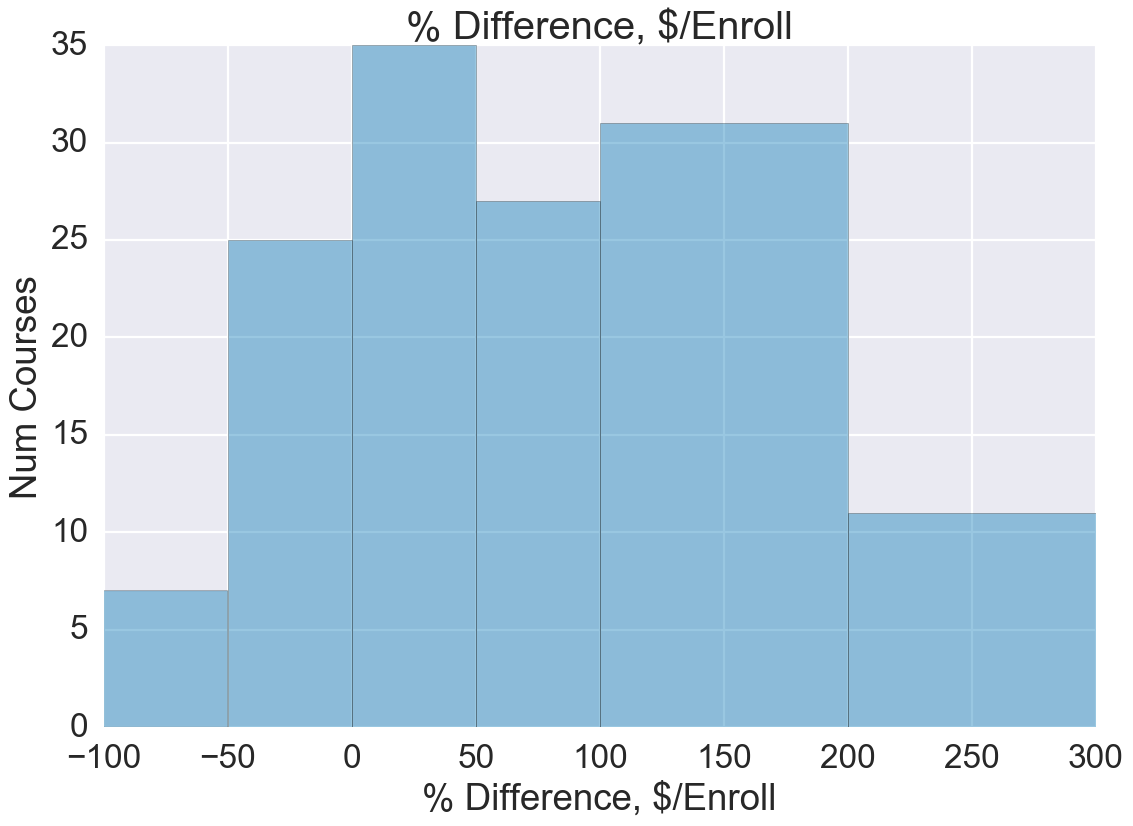

In [72]:
ax = sns.distplot(
    (df.pct_difference_expected_value),
    kde = False,
    color = '#0075b4',
    bins = [-100,-50,0,50,100,200,300])
ax.set(
    title = '% Difference, $/Enroll',
    xlabel = '% Difference, $/Enroll',
    ylabel = 'Num Courses'
)

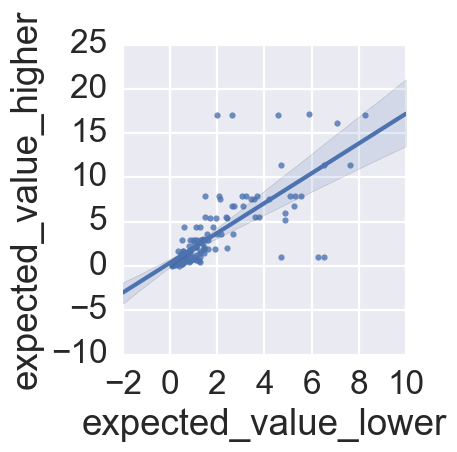

In [62]:
sns.lmplot(data = df, x= 'expected_value_lower', y = 'expected_value_higher')